In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

In [4]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/assign_bullets_para/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

### **Init**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [6]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [13]:
def print_example(idx, text, summ, summ_num_tok, bull):
    print(idx)
    print(fill(text, 100))
    print()
    print('Prediction (%d tokens):'%summ_num_tok)
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Print Examples

In [8]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():

        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt').to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)[0]
        summ_num_tok = len(summ_enc)
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print_example(idx, row.text, summ, summ_num_tok, row.bullets)

##### Plot Evaluation

In [9]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Karger Books Para**

In [10]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [14]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[+] model already present in cache

(9781912776696, 'hh-5')
Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor receptor 2 (HER2)-positive metastatic breast cancer treated either with or without
trastuzumab. The Kaplan-Meier curve steps down at time points at which deaths occur, while censored
observations are denoted by notches on the curve. In this study, the follow-up period ranged from 3
months to 74 months. The Kaplan-Meier curve plots the probability of being event free over time,
with these probabilities being estimated from the data in the study. Note that the curve for
patients who received trastuzumab is consistently above the curve for those who did not receive
trastuzumab, indicating a higher survival probability in that group.

Prediction (47 tokens):
 Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study o

(9781910797662, 'ch03')
Anorexia, nausea, weight loss and malaise may result from renal failure due to bilateral ureteric
obstruction, or from the systemic effects of the tumor itself. Bone pain or pathological fractures
may result from skeletal metastases (Figure 3.3); the pain is unrelieved by rest and can be severe.
Anemia and hypercalcemia may occur as metabolic complications of advanced disease; leukocytosis is
occasionally associated with the elaboration of colony-stimulating factors by the tumor. Headache or
disordered thought processes are uncommon as a presenting feature but may indicate underlying brain
metastases or carcinomatous meningitis.

Prediction (57 tokens):
 Anorexia, nausea, weight loss and malaise may result from renal failure due to bilateral ureteric
obstruction. Bone pain or pathological fractures may result from skeletal metastases. Anemia and
hypercalcemia may occur as metabolic complications of advanced disease.

Reference:
Recurrent infections may indicate 

In [15]:
print_examples(magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train', df_train)

[+] model already present in cache

(9781912776696, 'hh-5')
Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor receptor 2 (HER2)-positive metastatic breast cancer treated either with or without
trastuzumab. The Kaplan-Meier curve steps down at time points at which deaths occur, while censored
observations are denoted by notches on the curve. In this study, the follow-up period ranged from 3
months to 74 months. The Kaplan-Meier curve plots the probability of being event free over time,
with these probabilities being estimated from the data in the study. Note that the curve for
patients who received trastuzumab is consistently above the curve for those who did not receive
trastuzumab, indicating a higher survival probability in that group.

Prediction (38 tokens):
Kaplan-Meier curves plot the probability of being event free over ti

(9781910797310, 'chp2')
About 70% of patients present with advanced stage lung cancer. Diagnosis is usually made from small
biopsy and cytology specimens. Historically, pathologists only needed to distinguish between small-
cell lung cancer (SCLC) and non-small-cell lung cancer (NSCLC), but in recent years therapeutic and
genetic advances have driven the need for larger quantities of tissue for histological
subclassification, immunohistochemistry and molecular and immune pathology. The 2015 World Health
Organization Classification of Tumors of the Lung, Pleura, Thymus and Heart includes a new
classification for small biopsies and cytology similar to that proposed in the 2011 Association for
the Study of Lung Cancer/American Thoracic Society/European Respiratory Society classification.

Prediction (38 tokens):
The 2015 World Health Organization Classification of Lung Tumors recommends the use of
immunohistochemistry for the classification of non-small-cell lung cancer (NSCLC).

Referenc

##### Print Val Examples

In [16]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

[+] model already present in cache

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction (46 tokens):
 M

(9781910797815, 'chp9')
There are no specific diagnostic criteria for MPN-BP. The principal criterion is the same as for de
novo acute myeloid leukemia (AML): more than 20% blasts in bone marrow or peripheral blood.
Persistence is also important if only peripheral blood blasts are considered. Importantly,
acceleration or progression of myelofibrosis is usually apparent before the development of overt
leukemia. Signs of this include.

Prediction (47 tokens):
 There are no specific diagnostic criteria for MPN-BP. The principal criterion is the same as for de
novo acute myeloid leukemia (AML): more than 20% blasts in bone marrow or peripheral blood.

Reference:
Signs of accelerating myelofibrosis may precede the development of overt leukemia.

####################################################################################################

(9783318068207, 'hh-7')
Melanoma is a highly mutated malignancy, with mutations documented in all subtypes (Table 5.3)., The
KIT mutation is associ

In [17]:
print_examples(magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train', df_val)

[+] model already present in cache

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction (39 tokens):
Th

(9781910797815, 'chp9')
There are no specific diagnostic criteria for MPN-BP. The principal criterion is the same as for de
novo acute myeloid leukemia (AML): more than 20% blasts in bone marrow or peripheral blood.
Persistence is also important if only peripheral blood blasts are considered. Importantly,
acceleration or progression of myelofibrosis is usually apparent before the development of overt
leukemia. Signs of this include.

Prediction (15 tokens):
There are no specific diagnostic criteria for MPN-BP.

Reference:
Signs of accelerating myelofibrosis may precede the development of overt leukemia.

####################################################################################################

(9783318068207, 'hh-7')
Melanoma is a highly mutated malignancy, with mutations documented in all subtypes (Table 5.3)., The
KIT mutation is associated with chronic sun damage. The BRAF mutation is present in 11% of patients
with mucosal melanoma, NRAS mutation in 5% and KIT mutation i

##### Print Test Examples

In [18]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

[+] model already present in cache

(9781908541277, 'ch_8')
After a hiatus of nearly 20 years, 16 new AEDs and two devices - the vagus nerve stimulator and deep
brain stimulator - have received licenses for the adjunctive treatment of refractory epilepsy, the
last so far only in Europe. Gabapentin (GBP), lacosamide (LCM), LTG, levetiracetam (LEV),
oxcarbazepine (OXC), pregabalin (PGB), tiagabine (TGB), TPM and zonisamide (ZNS) are widely
available for partial seizures. Rufinamide (RFN) has been licensed in Europe and the USA for
adjunctive treatment of seizures in Lennox-Gastaut syndrome. Eslicarbazepine acetate (ESL) is
licensed in Europe as adjunctive treatment for partial seizures with or without secondary
generalization. Retigabine (RTG; ezogabine in the USA) and perampanel (PER) have recently been
approved for use in Europe and the USA for the same indication. After 20 years of global experience,
vigabatrin (VGB) has been approved in the USA for the treatment of infantile spasms a

(9781910797211, 'ch04')
The study started in 2000 with a median follow-up of 3 years and maximum of 7 years. During this
time the dopamine agonists varied, including ergot agonists that are no longer in widespread use.
The randomization to levodopa or alternative regimens was at the discretion of the clinician and a
large part of the study was conducted in centers for the care of the elderly. The findings suggest
relatively small but persistent benefits of starting therapy with levodopa rather than the listed
alternatives. Interestingly, initial treatment with a MAOB inhibitor appeared to be at least as
effective as treatment with a dopamine agonist. Patients assigned to the levodopa arm scored, on
average, 1.8 points (95% CI 0.5-3.0) higher on the Parkinson's Disease Questionnaire-39 (PDQ-39)
mobility subscale than those assigned to levodopa-sparing therapies; however, the effects on non-
motor aspects of the scale are unclear. A cost-utility analysis of the study will be reported
sep

In [19]:
print_examples(magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train', df_test)

[+] model already present in cache

(9781908541277, 'ch_8')
After a hiatus of nearly 20 years, 16 new AEDs and two devices - the vagus nerve stimulator and deep
brain stimulator - have received licenses for the adjunctive treatment of refractory epilepsy, the
last so far only in Europe. Gabapentin (GBP), lacosamide (LCM), LTG, levetiracetam (LEV),
oxcarbazepine (OXC), pregabalin (PGB), tiagabine (TGB), TPM and zonisamide (ZNS) are widely
available for partial seizures. Rufinamide (RFN) has been licensed in Europe and the USA for
adjunctive treatment of seizures in Lennox-Gastaut syndrome. Eslicarbazepine acetate (ESL) is
licensed in Europe as adjunctive treatment for partial seizures with or without secondary
generalization. Retigabine (RTG; ezogabine in the USA) and perampanel (PER) have recently been
approved for use in Europe and the USA for the same indication. After 20 years of global experience,
vigabatrin (VGB) has been approved in the USA for the treatment of infantile spasms a

(9781908541963, 'chapter5')
Liver transplantation is still the only effective treatment for advanced PBC. The indications for
transplantation are liver failure, defined by the Model for End-Stage Liver Disease (MELD) as a
disease severity score ranging from 4 to 40, typically above 20; severe and intractable pruritus;
and hepatocellular carcinoma The results of liver transplantation for PBC are excellent. There is
evidence that PBC recurs in the transplanted liver, but this phenomenon appears to be of little
clinical relevance in the first 10-15 years after transplantation.

Prediction (18 tokens):
Liver transplantation is still the only effective treatment for advanced PBC.

Reference:
Liver transplantation is an excellent treatment for end-stage AIH and PBC.

####################################################################################################

(9781910797426, 'ch03')
Etiology and pathogenesis. Chronic gallbladder inflammation is attributed as an etiologic factor in
ga

##### Summarize Test

In [20]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [21]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

[+] model already present in cache

100%|██████████| 25/25 [24:19<00:00, 58.37s/it]


In [32]:
df_test = summarize(magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train', df_test, 10)

[+] model already present in cache

100%|██████████| 25/25 [19:50<00:00, 47.63s/it]


### **Evaluation**

In [33]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [34]:
def evaluate_model(df, model_name_or_path):
    df_eval = df.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary_'+model_name_or_path: lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df_eval

In [35]:
evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

,,text,bullets,summary_sshleifer/distilbart-cnn-12-6,rouge1_precision_sshleifer/distilbart-cnn-12-6,rouge1_recall_sshleifer/distilbart-cnn-12-6,rouge1_fmeasure_sshleifer/distilbart-cnn-12-6,rouge2_precision_sshleifer/distilbart-cnn-12-6,rouge2_recall_sshleifer/distilbart-cnn-12-6,rouge2_fmeasure_sshleifer/distilbart-cnn-12-6,rougeL_precision_sshleifer/distilbart-cnn-12-6,rougeL_recall_sshleifer/distilbart-cnn-12-6,rougeL_fmeasure_sshleifer/distilbart-cnn-12-6
book,chapter,,,,,,,,,,,,
9781910797631,chp6,Universal versus selected prevention approache...,The treatment rather than the prevention of de...,A systematic review has identified good evide...,0.340659,0.360465,0.350282,0.038674,0.040936,0.039773,0.131868,0.139535,0.135593
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,Gallstones are a significant cause of morbidi...,0.445652,0.640625,0.525641,0.256831,0.370079,0.303226,0.304348,0.437500,0.358974
9781908541277,ch_12,Depression is the most prevalent psychiatric c...,Depression and anxiety are common in patients ...,"Depression is under-recognized and, when diag...",0.230769,0.463087,0.308036,0.057047,0.114865,0.076233,0.103679,0.208054,0.138393
9781910797907,chp6,Red blood cell (RBC) transfusions are frequent...,The decision for transfusion therapy relates t...,There is no set standard with regard to trans...,0.377660,0.541985,0.445141,0.122995,0.176923,0.145110,0.228723,0.328244,0.269592
9781908541277,ch_8,Dosage. CBZ should be introduced at low doses ...,This wider choice of AEDs permits pharmacologi...,CBZ should be introduced at low doses (100-20...,0.145038,0.365385,0.207650,0.015385,0.039216,0.022099,0.114504,0.288462,0.163934
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,"In the UK, respiratory admissions account for...",0.198157,0.483146,0.281046,0.050926,0.125000,0.072368,0.110599,0.269663,0.156863
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,People with schizophrenia exhibit decreased v...,0.281250,0.786408,0.414322,0.170732,0.480392,0.251928,0.232639,0.650485,0.342711
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,The adoption of broad NGS gene panels may sup...,0.242798,0.483607,0.323288,0.057851,0.115702,0.077135,0.144033,0.286885,0.191781
9781910797105,ch04,The most straightforward studies in population...,Having a close relative with schizophrenia inc...,"Usually, a series of individuals with schizop...",0.143541,0.422535,0.214286,0.024038,0.071429,0.035971,0.095694,0.281690,0.142857


In [37]:
evaluate_model(df_test, magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train')

,,text,bullets,summary_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rouge1_precision_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rouge1_recall_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rouge1_fmeasure_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rouge2_precision_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rouge2_recall_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rouge2_fmeasure_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rougeL_precision_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rougeL_recall_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train,rougeL_fmeasure_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train
book,chapter,,,,,,,,,,,,
9781910797631,chp6,Universal versus selected prevention approache...,The treatment rather than the prevention of de...,The most efficient and effective approaches fo...,0.424051,0.389535,0.406061,0.076433,0.070175,0.073171,0.189873,0.174419,0.181818
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,Gallstones are a significant cause of morbidit...,0.483607,0.460938,0.472000,0.256198,0.244094,0.250000,0.368852,0.351562,0.360000
9781908541277,ch_12,Depression is the most prevalent psychiatric c...,Depression and anxiety are common in patients ...,Depression is the most prevalent psychiatric c...,0.564286,0.530201,0.546713,0.330935,0.310811,0.320557,0.492857,0.463087,0.477509
9781910797907,chp6,Red blood cell (RBC) transfusions are frequent...,The decision for transfusion therapy relates t...,There is no standard for transfusions for pati...,0.473333,0.541985,0.505338,0.234899,0.269231,0.250896,0.333333,0.381679,0.355872
9781908541277,ch_8,Dosage. CBZ should be introduced at low doses ...,This wider choice of AEDs permits pharmacologi...,CBZ should be introduced at low doses with 100...,0.260870,0.346154,0.297521,0.029412,0.039216,0.033613,0.202899,0.269231,0.231405
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,Acute exacerbations of chronic obstructive pul...,0.283333,0.573034,0.379182,0.156425,0.318182,0.209738,0.238889,0.483146,0.319703
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,People with schizophrenia exhibit decreased vo...,0.351351,0.631068,0.451389,0.168478,0.303922,0.216783,0.254054,0.456311,0.326389
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,Despite increasing knowledge of the cancer mol...,0.475000,0.467213,0.471074,0.218487,0.214876,0.216667,0.308333,0.303279,0.305785
9781910797105,ch04,The most straightforward studies in population...,Having a close relative with schizophrenia inc...,Genetic risk factors are often used to assess ...,0.256098,0.295775,0.274510,0.049383,0.057143,0.052980,0.158537,0.183099,0.169935


##### Plot Evaluation

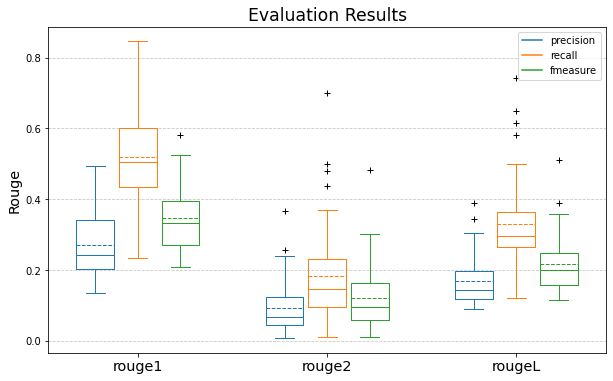

In [38]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')

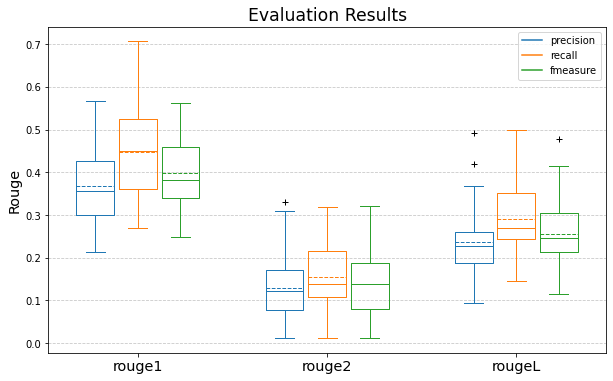

In [39]:
plot_evaluation(magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train')